In [ ]:
# Connecting  to Google Drive and Install MNE
from google.colab import drive
import os

# This gives your notebook access to your Google Drive files.
drive.mount('/content/drive')

# MNE is the essential library for EEG data processing.
!pip install mne

# --- Creating a clean folder structure for our project ---
project_path = '/content/drive/MyDrive/EEG_Schizophrenia_Project'
os.makedirs(os.path.join(project_path, 'processed_data'), exist_ok=True)
os.makedirs(os.path.join(project_path, 'models'), exist_ok=True)

print(f"✅ Project workspace is ready at: {project_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Project workspace is ready at: /content/drive/MyDrive/EEG_Schizophrenia_Project


In [ ]:
# listing all .edf files in the dataset directory
import glob
import os

dataset_path = '/content/drive/MyDrive/dataset'
edf_files = glob.glob(os.path.join(dataset_path, '*.edf'))

if not edf_files:
    print(f"❌ ERROR: No .edf files were found directly inside {dataset_path}")
    print("Please double-check the path.")
else:
    print(f"--- Found {len(edf_files)} .edf files in the dataset folder: ---")
    for file_path in sorted(edf_files):
        print(f"- {os.path.basename(file_path)}")

--- Found 28 .edf files in the dataset folder: ---
- h01.edf
- h02.edf
- h03.edf
- h04.edf
- h05.edf
- h06.edf
- h07.edf
- h08.edf
- h09.edf
- h10.edf
- h11.edf
- h12.edf
- h13.edf
- h14.edf
- s01.edf
- s02.edf
- s03.edf
- s04.edf
- s05.edf
- s06.edf
- s07.edf
- s08.edf
- s09.edf
- s10.edf
- s11.edf
- s12.edf
- s13.edf
- s14.edf


In [ ]:
# Cell 2 
import pandas as pd
import glob
import os
# --- Defining paths ---
dataset_path = '/content/drive/MyDrive/dataset'
project_path = '/content/drive/MyDrive/EEG_Schizophrenia_Project'

# --- Finding all .edf files ---
all_files = glob.glob(os.path.join(dataset_path, '*.edf'))

# --- Creating lists for file paths and labels ---
file_paths = []
labels = []

print("Scanning files and assigning labels...")
for file_path in all_files:
    filename = os.path.basename(file_path)
    if filename.startswith('s'):
        file_paths.append(file_path)
        labels.append(1) # 1 for Schizophrenia
    elif filename.startswith('h'):
        file_paths.append(file_path)
        labels.append(0) # 0 for Control / Healthy
    else:
        print(f"--> Skipping file with unknown naming convention: {filename}")

if not file_paths:
    print("❌ ERROR: No files starting with 's' or 'h' were found.")
else:
    print(f"Found and labeled {len(file_paths)} files.")

    # --- Creating DataFrame ---
    metadata_df = pd.DataFrame({'file_path': file_paths, 'label': labels})
    metadata_path = os.path.join(project_path, 'metadata.csv')
    metadata_df.to_csv(metadata_path, index=False)

    print(f"\nSuccessfully created metadata.csv.")
    print(f"File saved at: {metadata_path}")
    print("\n--- Here's a sample of your data map ---")
    print(metadata_df.sample(min(5, len(metadata_df))))

Scanning files and assigning labels...
Found and labeled 28 files.

Successfully created metadata.csv.
File saved at: /content/drive/MyDrive/EEG_Schizophrenia_Project/metadata.csv

--- Here's a sample of your data map ---
                                 file_path  label
5   /content/drive/MyDrive/dataset/h08.edf      0
14  /content/drive/MyDrive/dataset/s03.edf      1
26  /content/drive/MyDrive/dataset/s13.edf      1
17  /content/drive/MyDrive/dataset/s04.edf      1
11  /content/drive/MyDrive/dataset/h13.edf      0


In [ ]:
# Define the Processing Function
import mne
import numpy as np
from scipy import signal

def process_file_to_features(file_path):
    """Processes one EEG file into multiple feature images (spectrograms)."""
    try:
        raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
        raw.pick_types(eeg=True)
        raw.filter(l_freq=1.0, h_freq=45.0, verbose=False)
        epochs = mne.make_fixed_length_epochs(raw, duration=5.0, overlap=2.5, verbose=False)
        epoch_data = epochs.get_data()
        features = []
        for single_epoch_data in epoch_data:
            channel_spectrograms = []
            for channel_signal in single_epoch_data:
                fs = raw.info['sfreq']
                freqs, times, Sxx = signal.spectrogram(channel_signal, fs=fs, nperseg=128, noverlap=64)
                Sxx_db = 10 * np.log10(Sxx + 1e-10)
                channel_spectrograms.append(Sxx_db)
            avg_spectrogram = np.mean(channel_spectrograms, axis=0)
            features.append(avg_spectrogram)
        return features
    except Exception as e:
        print(f"--> Could not process file {os.path.basename(file_path)}. Reason: {e}")
        return []

# Run the Full Processing Pipeline
from tqdm.notebook import tqdm

processed_data_path = os.path.join(project_path, 'processed_data')
df = pd.read_csv(metadata_path)
feature_count = 0
for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing Files"):
    file_path = row['file_path']
    label = row['label']
    features = process_file_to_features(file_path)
    for feature in features:
        save_path = os.path.join(processed_data_path, f"feature_{feature_count}_label_{label}.npy")
        np.save(save_path, feature)
        feature_count += 1

print(f"\n✅ Finished processing. Created {feature_count} feature images.")

Processing Files:   0%|          | 0/28 [00:00<?, ?it/s]

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 369 events and 1250 original time points ...
0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 363 events and 1250 original time points ...
0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 377 events and 1250 original time points ...
0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 361 events and 1250 original time points ...
0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 371 events and 1250 original time points ...
0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 363 

In [ ]:
# Defining the PyTorch Dataset Class
import torch
from torch.utils.data import Dataset, DataLoader
import glob

class EEGDataset(Dataset):
    def __init__(self, data_path):
        self.file_list = glob.glob(os.path.join(data_path, '*.npy'))
        if not self.file_list:
            raise ValueError("No .npy files found. Did the preprocessing step fail?")

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = self.file_list[idx]
        feature = np.load(file_path)
        label = int(os.path.basename(file_path).split('_label_')[1].replace('.npy', ''))
        feature_tensor = torch.from_numpy(feature).float().unsqueeze(0)
        label_tensor = torch.tensor(label, dtype=torch.float32)
        return feature_tensor, label_tensor

# Split Data and Create DataLoaders
from sklearn.model_selection import train_test_split

processed_data_path = '/content/drive/MyDrive/EEG_Schizophrenia_Project/processed_data'
full_dataset = EEGDataset(processed_data_path)
print(f"Total samples found: {len(full_dataset)}")

train_indices, temp_indices = train_test_split(list(range(len(full_dataset))), test_size=0.3, random_state=42)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42)

train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
val_dataset = torch.utils.data.Subset(full_dataset, val_indices)
test_dataset = torch.utils.data.Subset(full_dataset, test_indices)

print(f"Training samples:   {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples:       {len(test_dataset)}")

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Total samples found: 11515
Training samples:   8060
Validation samples: 1727
Test samples:       1728


In [ ]:
# Defining the UPGRADED CNN Model Architecture
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import torch

class UpgradedCNN(nn.Module):
    def __init__(self, input_size):
        super(UpgradedCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1) # Flatten the output for the fully connected layers
        x = self.fc_layers(x)
        return x

# Configure the Training Environment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Get a sample batch of data to know its dimensions
sample_batch, _ = next(iter(train_loader))
# 2. Create a temporary model with a placeholder size
temp_model = UpgradedCNN(1).to(device)
# 3. Pass the sample data ONLY through the convolutional layers
with torch.no_grad():
    conv_output = temp_model.conv_layers(sample_batch.to(device))
# 4. Calculate the flattened size of the output
num_features = conv_output.view(conv_output.size(0), -1).shape[1]
print(f"Correctly calculated feature size for the new model: {num_features}")

# --- Initialize the final model with the CORRECT size ---
model = UpgradedCNN(num_features).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# The Training Loop (for 50 Epochs)
from tqdm.notebook import tqdm

project_path = '/content/drive/MyDrive/EEG_Schizophrenia_Project'
N_EPOCHS = 50 # We can adjust this number
best_val_loss = float('inf')
model_save_path = os.path.join(project_path, 'models/best_model_upgraded.pth')

for epoch in range(N_EPOCHS):
    model.train()
    train_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{N_EPOCHS}"):
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_dataset)
    val_loss /= len(val_dataset)
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), model_save_path)
        print("   -> Validation loss decreased. Saving best upgraded model...")

Using device: cuda
Correctly calculated feature size for the new model: 1024


Epoch 1/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.6941 | Val Loss: 0.6899
   -> Validation loss decreased. Saving best upgraded model...


Epoch 2/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.6891 | Val Loss: 0.6904


Epoch 3/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.6882 | Val Loss: 0.6905


Epoch 4/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.6887 | Val Loss: 0.6904


Epoch 5/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.6881 | Val Loss: 0.6900


Epoch 6/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.6886 | Val Loss: 0.6900


Epoch 7/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.6879 | Val Loss: 0.6904


Epoch 8/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.6882 | Val Loss: 0.6899


Epoch 9/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.6444 | Val Loss: 0.7699


Epoch 10/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.5580 | Val Loss: 0.6225
   -> Validation loss decreased. Saving best upgraded model...


Epoch 11/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.5201 | Val Loss: 0.8706


Epoch 12/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.4941 | Val Loss: 0.8834


Epoch 13/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.4776 | Val Loss: 0.7176


Epoch 14/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.4563 | Val Loss: 0.6095
   -> Validation loss decreased. Saving best upgraded model...


Epoch 15/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.4445 | Val Loss: 0.5514
   -> Validation loss decreased. Saving best upgraded model...


Epoch 16/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.4312 | Val Loss: 0.5386
   -> Validation loss decreased. Saving best upgraded model...


Epoch 17/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.4199 | Val Loss: 0.4733
   -> Validation loss decreased. Saving best upgraded model...


Epoch 18/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.4090 | Val Loss: 0.6471


Epoch 19/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.4010 | Val Loss: 0.5185


Epoch 20/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.3877 | Val Loss: 1.1571


Epoch 21/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.3781 | Val Loss: 0.4032
   -> Validation loss decreased. Saving best upgraded model...


Epoch 22/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.3678 | Val Loss: 0.4276


Epoch 23/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.3605 | Val Loss: 0.8399


Epoch 24/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.3557 | Val Loss: 0.4362


Epoch 25/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.3495 | Val Loss: 0.3544
   -> Validation loss decreased. Saving best upgraded model...


Epoch 26/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.3448 | Val Loss: 0.3558


Epoch 27/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.3375 | Val Loss: 0.6906


Epoch 28/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.3296 | Val Loss: 0.3296
   -> Validation loss decreased. Saving best upgraded model...


Epoch 29/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.3281 | Val Loss: 0.4557


Epoch 30/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.3196 | Val Loss: 1.3935


Epoch 31/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.3203 | Val Loss: 1.2825


Epoch 32/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.3084 | Val Loss: 0.6053


Epoch 33/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.3092 | Val Loss: 2.7777


Epoch 34/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.3043 | Val Loss: 0.9148


Epoch 35/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.2989 | Val Loss: 0.4656


Epoch 36/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.2958 | Val Loss: 0.4253


Epoch 37/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.2885 | Val Loss: 0.3003
   -> Validation loss decreased. Saving best upgraded model...


Epoch 38/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.2851 | Val Loss: 1.6552


Epoch 39/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.2820 | Val Loss: 1.2962


Epoch 40/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.2792 | Val Loss: 0.4241


Epoch 41/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.2751 | Val Loss: 0.5196


Epoch 42/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.2756 | Val Loss: 0.3469


Epoch 43/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.2684 | Val Loss: 0.2804
   -> Validation loss decreased. Saving best upgraded model...


Epoch 44/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.2685 | Val Loss: 0.8252


Epoch 45/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.2642 | Val Loss: 0.3432


Epoch 46/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.2616 | Val Loss: 1.1623


Epoch 47/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.2627 | Val Loss: 0.7629


Epoch 48/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.2549 | Val Loss: 0.6412


Epoch 49/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.2544 | Val Loss: 0.7781


Epoch 50/50:   0%|          | 0/252 [00:00<?, ?it/s]

Train Loss: 0.2520 | Val Loss: 0.2825



--- Final Test Set Evaluation (Upgraded Model) ---
Accuracy:  0.8872
Precision: 0.9007
Recall:    0.8860
F1-Score:  0.8933


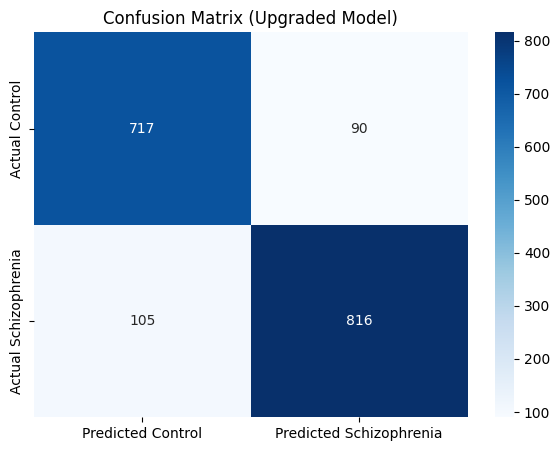

In [ ]:
# Evaluate the Model on the Test Set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


project_path = '/content/drive/MyDrive/EEG_Schizophrenia_Project'
model_save_path = os.path.join(project_path, 'models/best_model_upgraded.pth')

# Re-initialize the upgraded model structure to load the weights
model = UpgradedCNN(num_features).to(device) # Make sure to use the UpgradedCNN class
model.load_state_dict(torch.load(model_save_path))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs).squeeze()
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).int()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, zero_division=0)
recall = recall_score(all_labels, all_preds, zero_division=0)
f1 = f1_score(all_labels, all_preds, zero_division=0)

print("\n--- Final Test Set Evaluation (Upgraded Model) ---")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Ploting a confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Control', 'Predicted Schizophrenia'],
            yticklabels=['Actual Control', 'Actual Schizophrenia'])
plt.title('Confusion Matrix (Upgraded Model)')
plt.show()

In [ ]:
# Simple Model for Classifying a Single EDF File

def classify_eeg_file_upgraded(file_path, model_path, model_input_size):
    """
    Takes a path to a single EDF file and classifies it using the UPGRADED model.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Make sure to initialize the correct model architecture
    model = UpgradedCNN(model_input_size).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    print(f"Processing file: {os.path.basename(file_path)}...")
    features = process_file_to_features(file_path) # Uses the function from Cell 3

    if not features:
        print("Could not extract any valid features from this file.")
        return

    predictions = []
    with torch.no_grad():
        for feature in features:
            feature_tensor = torch.from_numpy(feature).float().unsqueeze(0).unsqueeze(0).to(device)
            output = model(feature_tensor).squeeze()
            prob = torch.sigmoid(output)
            prediction = (prob > 0.5).int().item()
            predictions.append(prediction)

    if not predictions:
        print("Prediction failed.")
        return

    sch_votes = sum(predictions)
    control_votes = len(predictions) - sch_votes
    sch_percentage = (sch_votes / len(predictions)) * 100

    print(f"Analysis complete. Found {len(predictions)} segments.")
    print(f"Schizophrenia predictions: {sch_votes}")
    print(f"Control predictions:     {control_votes}")
    print("---" * 10)

    if sch_votes > control_votes:
        print(f"✅ FINAL RESULT: The model classifies this as LIKELY SCHIZOPHRENIA ({sch_percentage:.2f}% confidence).")
    else:
        print(f"✅ FINAL RESULT: The model classifies this as LIKELY A HEALTHY CONTROL ({100-sch_percentage:.2f}% confidence).")

# --- EXAMPLE USAGE ---
model_save_path = '/content/drive/MyDrive/EEG_Schizophrenia_Project/models/best_model_upgraded.pth'

# 1. Test a schizophrenia file
print("--- TESTING A SCHIZOPHRENIA FILE ---")
test_file_s = '/content/drive/MyDrive/dataset/s01.edf'
classify_eeg_file_upgraded(test_file_s, model_save_path, num_features)

print("\n" + "==="*20 + "\n")

# 2. Test a control file
print("--- TESTING A CONTROL FILE ---")
test_file_h = '/content/drive/MyDrive/dataset/h01.edf'
classify_eeg_file_upgraded(test_file_h, model_save_path, num_features)

--- TESTING A SCHIZOPHRENIA FILE ---
Processing file: s01.edf...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 337 events and 1250 original time points ...
0 bad epochs dropped
Analysis complete. Found 337 segments.
Schizophrenia predictions: 264
Control predictions:     73
------------------------------
✅ FINAL RESULT: The model classifies this as LIKELY SCHIZOPHRENIA (78.34% confidence).


--- TESTING A CONTROL FILE ---
Processing file: h01.edf...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 369 events and 1250 original time points ...
0 bad epochs dropped
Analysis complete. Found 369 segments.
Schizophrenia predictions: 25
Control predictions:     344
------------------------------
✅ FINAL RESULT: The model classifies this as LIKELY A HEALTHY CONTROL (93.22% confidence).
